# Assignment 9.1 - Backpropagation

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf. <br><br>
Please do **NOT** rename the file!

#### State both names of your group members here:
Farah Ahmed Atef Abdelhameed Hafez

## Task 9.1.1: Backpropagation

* Implement a two-layer artificial neural network using `numpy` and/or `torch`with two input neurons and one output neuron. Choose the number of hidden neurons to your liking. **(RESULT)**
* Implement a train function that runs the backpropagation algorithm. Don't use `PyTorch`'s autograd functionality. **(RESULT)**
* Our goal is to learn the XOR function. What does the network return for random weights of all combinations of (binary) inputs? **(RESULT)**

Further reading: Rojas book (https://www.inf.fu-berlin.de/inst/ag-ki/rojas_home/documents/1996/NeuralNetworks/neuron.pdf), chapter 7.3.3 and learn about the "matrix way" of implementing backprop.

In [27]:
# Imports
import numpy as np
import torch


# Helper functions
def normalize(data, mean=None, variance=None, ret=False):
    """Normalizes the data to allow for faster convergence of the gradient ascent"""
    if mean is None:
        mean = np.mean(data, axis=0)[np.newaxis,:]
    if variance is None:
        std = np.std(data, axis=0)[np.newaxis,:]
    std[np.where(std == 0)] = 1
    data_ = (data - mean) / std
    if ret:
        return data_
    else:
        return data_, mean, std

def onehot(labels, k):
    n = len(labels)
    onehot_labels = np.zeros([n, k])
    onehot_labels[range(n), labels] = 1
    return onehot_labels

In [28]:
class NN:   # Feel free to adjust the class structure / functions.
    def __init__(self, input_size=2, hidden_size=4, output_size=2, learning_rate=0.1, epochs=10000, batch_size=2):
        self.weights1 = np.random.randn(hidden_size, input_size+1).astype(np.float32) *0.5
        self.weights2 = np.random.randn(output_size, hidden_size+1).astype(np.float32)*0.5

        self.sigderv1 = np.zeros((batch_size, hidden_size, hidden_size))
        self.sigderv2 = np.zeros((batch_size, output_size, output_size))
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.lossHistory=[]

    def sigmoid(self, x):
      return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, x):
      return x * (1 - x)

    def train(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        self.X=X
        for i in range(self.epochs):
            m=0
            n= self.batch_size
            totalloss=0
            # for l in range(int(X.shape[0]/self.batch_size)):
            for l in range(0, X.shape[0], self.batch_size):
              self.feedforward(X[m:n], True)
              if y.ndim==1:
                y=y.reshape(-1, 1)
              loss= (1/2*self.batch_size)* np.sum((self.layer2 - y[m:n].T) ** 2)
              totalloss+=loss
              errorsderv=(1/self.batch_size)*(self.layer2 -y[m:n].T)

              updates1, updates2 = self.backprop(errorsderv.T, X[m:n])
              self.optimize(updates1, updates2)
              m+=self.batch_size
              n+=self.batch_size
            avgloss= totalloss/int(np.ceil(X.shape[0] / self.batch_size))
            print("Epoch", i, "Average loss, ", avgloss)
            self.lossHistory.append(avgloss)

    def feedforward(self, X, train_mode=False):
        """Feed-forward given input and weight matrices W1 and W2."""
        # print(self.weights1.shape)
        # print(X.shape)
        templayer1 = np.dot(self.weights1, X.T)
        self.layer1 = self.sigmoid(templayer1)
        # print(self.layer1.shape)

        bias_hidden = np.ones((1, self.layer1.shape[1]))
        self.layer1 = np.vstack([bias_hidden, self.layer1])
        templayer2= np.dot(self.weights2, self.layer1)
        self.layer2 = self.sigmoid(templayer2)
        if train_mode:
          for j in range(X.shape[0]):
              np.fill_diagonal(self.sigderv1[j], self.sigmoid_derivative(self.layer1[1:,j]))
              np.fill_diagonal(self.sigderv2[j], self.sigmoid_derivative(self.layer2[:, j]))

        return self.layer2


    def backprop(self, errorderv, X):
      update2temp=np.zeros_like(self.weights2)
      update1temp=np.zeros_like(self.weights1)
      for j in range(X.shape[0]):
        properrors2=np.dot(self.sigderv2[j], errorderv[j].reshape(-1, 1))
        # print(self.sigderv2[j].shape)
        # print(errorderv[j].reshape(-1,1).shape)
        # print(properrors2.shape)
        properrors1= np.dot(np.dot(self.sigderv1[j], self.weights2[:,1:].T),  properrors2)

        update2temp+= np.dot(properrors2, self.layer1[:,j].reshape(1, -1))
        update1temp+= np.dot(properrors1, X[j].reshape(1, -1))
      updates2=- self.learning_rate*update2temp
      updates1= - self.learning_rate*update1temp
      return updates1, updates2

    def optimize(self, updates1, updates2):
        """Update step"""
        self.weights1 = self.weights1 + updates1
        self.weights2 = self.weights2 + updates2


    def predict(self, X):
      xor_datatest = np.hstack([np.ones([X.shape[0], 1]), X])
      y=self.feedforward(xor_datatest).T
      result = np.zeros_like(y)
      for i in range(X.shape[0]):
        result[i, np.argmax(y[i])] = 1
      return  result


In [29]:
# XOR dataset
xor_data = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1],
])
xor_labels = onehot(np.array([0, 1, 1, 0]), 2)
print(xor_labels.shape)
print(xor_labels)

(4, 2)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


#Random weights

In [30]:
myNN= NN()
print(myNN.predict(xor_data))

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


50% Accuracy as seen above

## Task 9.1.2: Backpropagation

Implement Backpropagation and optimize the weights of your neural network using the XOR dataset:

| x | y |
| -------- | ------- |
| (0,0) | 0 |
| (0,1) | 1 |
| (1,0) | 1 |
| (1,1) | 0 |

* How many training iterations do you need? Plot the network error over the number of iterations **(RESULT)**

In [31]:
import matplotlib.pyplot as plt

In [32]:
myNN= NN(epochs=7000, batch_size=1)
myNN.train(xor_data, xor_labels)
print(myNN.predict(xor_data))

Streaming output truncated to the last 5000 lines.
Epoch 2004 Average loss,  0.14206137923217266
Epoch 2005 Average loss,  0.14191873091695667
Epoch 2006 Average loss,  0.14177590262793482
Epoch 2007 Average loss,  0.14163289509248578
Epoch 2008 Average loss,  0.14148970028018856
Epoch 2009 Average loss,  0.14134632653041956
Epoch 2010 Average loss,  0.14120277715076848
Epoch 2011 Average loss,  0.14105904701578037
Epoch 2012 Average loss,  0.14091513150205837
Epoch 2013 Average loss,  0.14077104561352957
Epoch 2014 Average loss,  0.14062678408903198
Epoch 2015 Average loss,  0.14048234319800756
Epoch 2016 Average loss,  0.14033773355495519
Epoch 2017 Average loss,  0.14019294158183387
Epoch 2018 Average loss,  0.14004798158105602
Epoch 2019 Average loss,  0.139902840982915
Epoch 2020 Average loss,  0.13975753084335124
Epoch 2021 Average loss,  0.1396120443266865
Epoch 2022 Average loss,  0.13946639596981575
Epoch 2023 Average loss,  0.13932056844015103
Epoch 2024 Average loss,  0.1391

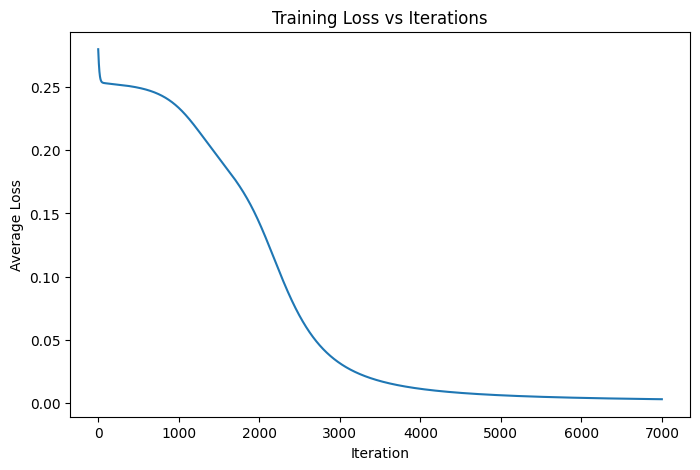

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(myNN.lossHistory)
plt.xlabel("Iteration")
plt.ylabel("Average Loss")
plt.title("Training Loss vs Iterations")
plt.show()

7000 epochs were used

## Task 9.1.3: MNIST (BONUS)

* Train your network on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) and state the model accuracy (or the model error) for the training and test sets. **(RESULT)**
* Compare to this [list](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354) and report on the performance of your model. **(RESULT)**

In [34]:
# You can access MNIST using torchvision (https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)
import torchvision.datasets as datasets

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=None)

mnist_train_data = mnist_train.data.numpy()
mnist_train_labels = mnist_train.targets.numpy()
mnist_test_data = mnist_test.data.numpy()
mnist_test_labels = mnist_test.targets.numpy()

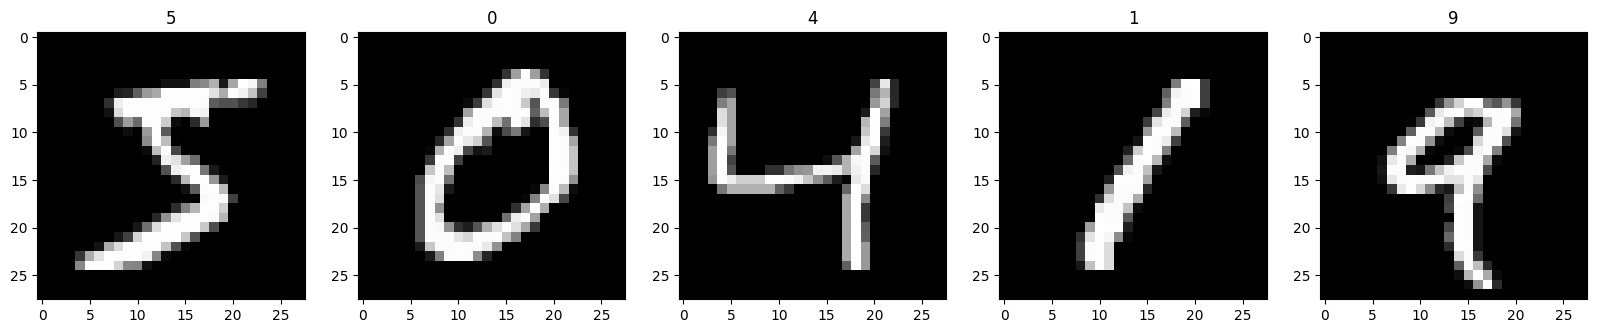

In [35]:
images, labels = mnist_train_data[:5], mnist_train_labels[:5]

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    axes[i].set_title(labels[i])
    axes[i].imshow(images[i], cmap='gray')

In [36]:
mnist_train_data_, mean, mu = normalize(mnist_train_data.reshape([-1, 28*28]))
mnist_train_labels_ = onehot(mnist_train_labels, 10)

In [37]:
# TODO: Implement

Ok-ish performance (error-rate 7%+), still a large gap to state-of-the-art models (error-rate 0.21%).

## Congratz, you made it! :)